<h1 style="text-align:center;font-size:30px;" > Mercari Price Suggestion </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>It can be hard to know how much something’s really worth. Small details can mean big differences in pricing.</p>

<p>Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.</p>

<p>Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.</p>

<p>In this case study, we try to build an algorithm that automatically suggests the right product prices. The input consists of user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.
</p>
<br>
> Credits: Kaggle 

<h3>Problem Statement:- </h3>
<li>Suggest the price to the product based on the input given by the user.

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/mercari-price-suggestion-challenge

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.tsv</b> contains 8 columns: train_id, name, item_condition_id, category_name, brand_name, shipping, item_description, price.<br/>
<b>Test.tsv</b> contains the same columns but without the price, which is to be predicted.<br />
<b>Size of Train.tsv</b> - 322 MB<br />
<b>Size of Test.tsv</b> - 147 MB<br />
<b>Number of rows in Train.tsv</b> = 1482535<br />
</pre>

__Data Field Explaination__

Train Dataset contains 1,482,535 rows. <br>
Test Dataset contains 693,359 rows.<br>The columns in the table are:<br />
<pre>
<b>train_id or test_id</b> - the id of the listing<br />
<b>name</b> - the title of the listing<br />
<b>item_condition_id</b> - the condition of the items provided by the seller<br />
<b>category_name</b> - category of the listing<br />
<b>brand_name</b> - <br />
<b>price</b> - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv<br />
<b>shipping</b> - boolean value, 1 if shipping fee is paid by seller and 0 by buyer<br />
<b>item_description</b> - the full description of the item<br />

</pre>

<br />

<h3> 2.1.2 Example Data point </h3>

<pre>
train_id	name	item_condition_id	category_name	brand_name	price	shipping	item_description
0	MLB Cincinnati Reds T Shirt Size XL	3	Men/Tops/T-shirts		10.0	1	No description yet
1	Razer BlackWidow Chroma Keyboard	3	Electronics/Computers & Tablets/Components & Parts	Razer	52.0	0	This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
2	AVA-VIV Blouse	1	Women/Tops & Blouses/Blouse	Target	10.0	1	Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!
3	Leather Horse Statues	1	Home/Home Décor/Home Décor Accents		35.0	1	New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
4	24K GOLD plated rose	1	Women/Jewelry/Necklaces		44.0	0	Complete with certificate of authenticity
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a Regression problem, for a given input information about the item we need ti predict the price. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview/evaluation
<br><br>
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as

![RMSLE.PNG](attachment:RMSLE.PNG)

Where:

ϵ is the RMSLE value (score)<br>
n is the total number of observations in the data set,<br>
p_i is your prediction of price,<br>
a_i is the actual sale price for i.<br>
log(x) is the natural logarithm of x<br>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime

## Loading the data

In [2]:
#loading train data
data_train=pd.read_csv('train.tsv',sep='\t')
print('Shape of the train data is : ',data_train.shape)
data_train.head() 

Shape of the train data is :  (1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
test=pd.read_csv('test_stg2.tsv',sep='\t')
print('Shape of the test data is : ',test.shape)
test.head() 

Shape of the test data is :  (3460725, 7)


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [4]:
#creating copies of train data
train=data_train.copy()

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


### Data Cleaning

In [6]:
#checking for rows which have price = 0
df = train[train['price'] == 0].reset_index(drop=True)
print('Number of rows with price = 0 are :',df.shape[0])

Number of rows with price = 0 are : 874


In [5]:
#dropping rows from train data where price=0
train = train[train['price'] > 0].reset_index(drop=True)
train.shape

(1481661, 8)

In [8]:
#checking for null values in columns
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

<li>The columns category_name , brand_name , item_description have null values

In [6]:
#filling null values
train.category_name.fillna(value="Unknown/Unknown/Unknown", inplace = True)
train.brand_name.fillna(value="Unknown", inplace = True)
train.item_description.fillna(value="No description yet", inplace = True)
test.category_name.fillna(value="Unknown/Unknown/Unknown", inplace = True)
test.brand_name.fillna(value="Unknown", inplace = True)
test.item_description.fillna(value="No description yet", inplace = True)

In [9]:
train.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Unknown,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...


## Splitting category_name

In [7]:
#splitting the category_name column into 3 columns-main_category,sub_cat1,sub_cat2
category=list(train['category_name'].values)

main_cat=[]
sub_cat1=[]
sub_cat2=[]
for i in range(len(category)):
    cat=category[i].split("/")
    main_cat.append(cat[0])
    sub_cat1.append(cat[1])
    sub_cat2.append(cat[2])

train['main_category']=main_cat
train['sub_cat1']=sub_cat1
train['sub_cat2']=sub_cat2

#dropping the column category_name
train.drop('category_name', axis=1, inplace=True)


In [8]:
train.head(2)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_category,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Unknown,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts


In [9]:
#splitting the category_name column into 3 columns-main_category,sub_cat1,sub_cat2
category=list(test['category_name'].values)

main_cat=[]
sub_cat1=[]
sub_cat2=[]
for i in range(len(category)):
    cat=category[i].split("/")
    main_cat.append(cat[0])
    sub_cat1.append(cat[1])
    sub_cat2.append(cat[2])

test['main_category']=main_cat
test['sub_cat1']=sub_cat1
test['sub_cat2']=sub_cat2

#dropping the column category_name
test.drop('category_name', axis=1, inplace=True)


In [10]:
test.head(2)

,test_id,name,item_condition_id,brand_name,shipping,item_description,main_category,sub_cat1,sub_cat2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Unknown,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Unknown,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies


## 1. Price

In [0]:
train['price'].describe()

count    1.481661e+06
mean     2.675329e+01
std      3.859198e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [0]:
#@title Default title text
price=train['price'].values
log_price = np.log1p(price)

In [0]:
p=np.array(price)
r=np.arange(10,110,10)
q1=np.percentile(p,r)
for i in range(len(r)):
    print(str(r[i])+'th percentile value of price =',q1[i])

10th percentile value of price = 7.0
20th percentile value of price = 10.0
30th percentile value of price = 12.0
40th percentile value of price = 14.0
50th percentile value of price = 17.0
60th percentile value of price = 20.0
70th percentile value of price = 26.0
80th percentile value of price = 34.0
90th percentile value of price = 51.0
100th percentile value of price = 2009.0


In [0]:
p=np.array(price)
r=np.arange(90,101,1)
q1=np.percentile(p,r)
for i in range(len(r)):
    print(str(r[i])+'th percentile value of price =',q1[i])

90th percentile value of price = 51.0
91th percentile value of price = 55.0
92th percentile value of price = 58.0
93th percentile value of price = 62.0
94th percentile value of price = 67.0
95th percentile value of price = 75.0
96th percentile value of price = 85.0
97th percentile value of price = 99.0
98th percentile value of price = 122.0
99th percentile value of price = 170.0
100th percentile value of price = 2009.0


### PDF of price :-

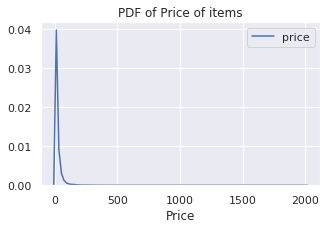

In [0]:
plt.figure(figsize=(5,3))
sns.distplot(price, hist=False, label="price")
plt.title('PDF of Price of items')
plt.xlabel('Price')
plt.legend()


### PDF of log(price) :-

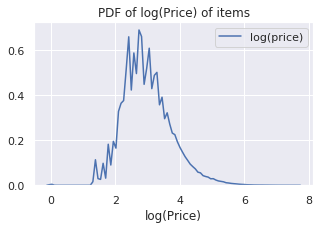

In [0]:
plt.figure(figsize=(5,3))
sns.distplot(log_price, hist=False, label="log(price)")
plt.title('PDF of log(Price) of items')
plt.xlabel('log(Price)')
plt.legend()
plt.show()

### Histograms

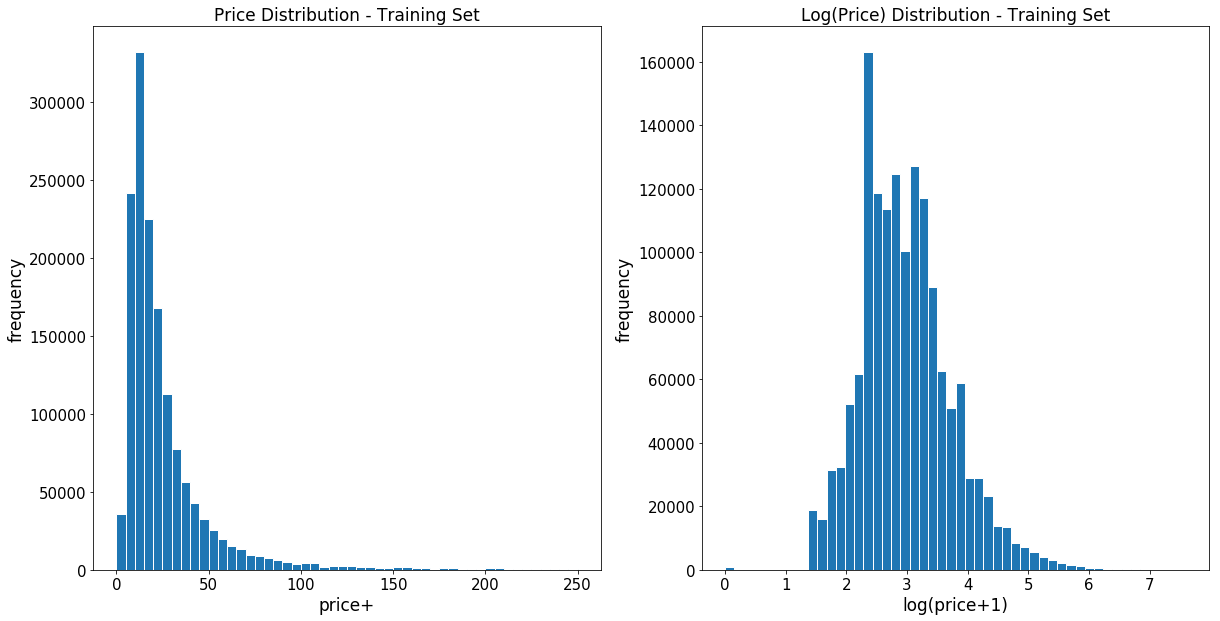

In [0]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

#### Observations :-
- 90 % of data points have price less than 51$
- 97 % of data points have price less than 99 
- Log(price) distribution is more symmetric when compared to price distribution
- That is why we use RMLSE as error metric and not RMSE


## 2. Main_category

In [0]:
sns.set(rc={'figure.figsize':(13,5)})

Number of unique main categories :  11


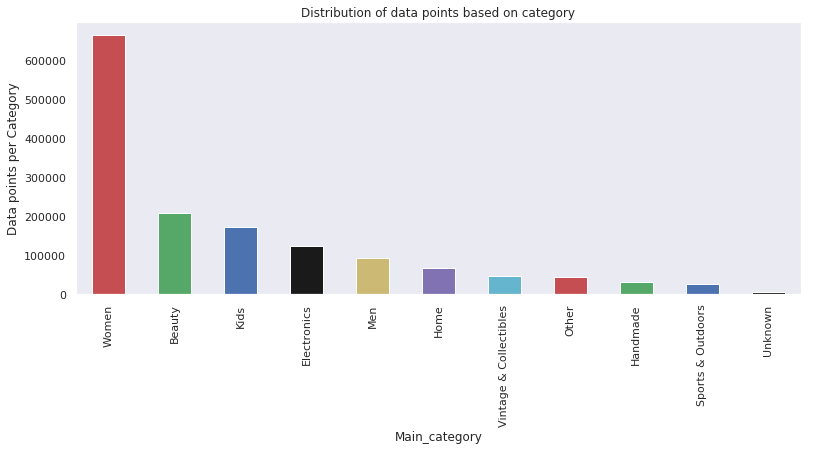

,Main_Category,data points count,%
0,Women,663990,44.81
1,Beauty,207725,14.02
2,Kids,171555,11.58
3,Electronics,122632,8.28
4,Men,93609,6.32
5,Home,67831,4.58
6,Vintage & Collectibles,46519,3.14
7,Other,45329,3.06
8,Handmade,30835,2.08
9,Sports & Outdoors,25322,1.71


In [0]:
main_cat=train['main_category'].value_counts()
print('Number of unique main categories : ',main_cat.size)

my_colors = ['r','g','b','k','y','m','c']
main_cat.plot(kind='bar',color=my_colors)
plt.xlabel('Main_category')
plt.ylabel('Data points per Category')
plt.title('Distribution of data points based on category')
plt.grid()
plt.show()


keys=list(main_cat.keys())
values=list(main_cat.values)
percentage=[]
for i in range(len(main_cat)):
    percent=np.round(float(values[i]/len(train))*100,2)
    percentage.append(percent)    
df=pd.DataFrame()
df['Main_Category']=keys
df['data points count']=values
df['%']=percentage
df

#### Observations :-
- There are a total 11 unique main categories
- Women category itself contains almost 45% of the data points
- The top 3 categories Women,Beauty,Kids contain 60% of data points
- 0.43% of the data do not contain the category information

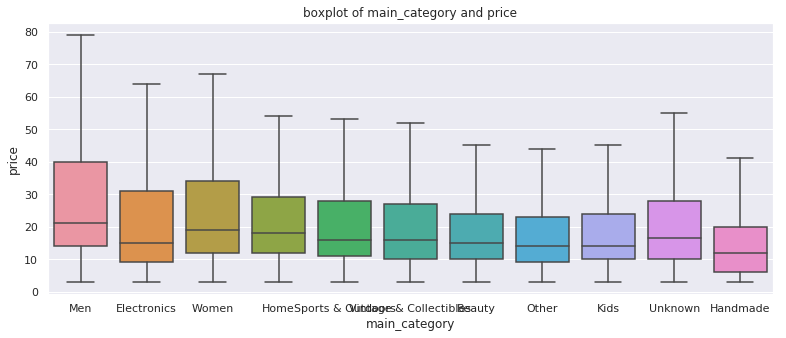

In [0]:
#boxplot of byte files
ax = sns.boxplot(x=train['main_category'], y=train['price'],showfliers = False, orient = "v")
plt.title("boxplot of main_category and price")
plt.plot(figsize=(30,30))
plt.show()

#### Observations :-
- The data points belonging to Men category have a highest price range when compared to other categories
- The data points belonging to Handmade category have a lowest price range when compared to other categories

## 3. sub_cat1

Number of unique sub categories 1 :  114


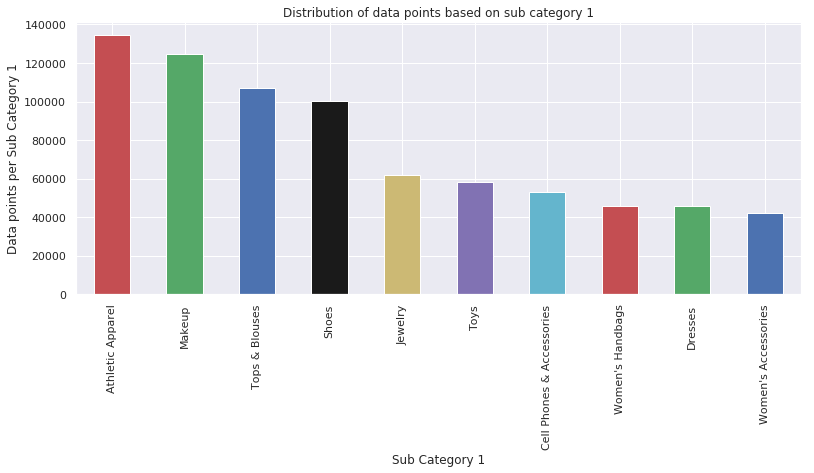

,sub_cat1,data points count,%
0,Athletic Apparel,134383,9.06
1,Makeup,124624,8.41
2,Tops & Blouses,106960,7.21
3,Shoes,100452,6.78
4,Jewelry,61763,4.17
5,Toys,58158,3.92
6,Cell Phones & Accessories,53290,3.59
7,Women's Handbags,45862,3.09
8,Dresses,45758,3.09
9,Women's Accessories,42350,2.86


In [0]:
sub_cat1=train['sub_cat1'].value_counts()
print('Number of unique sub categories 1 : ',sub_cat1.size)

my_colors = ['r','g','b','k','y','m','c']
sub_cat1[0:10].plot(kind='bar',color=my_colors)
plt.xlabel('Sub Category 1')
plt.ylabel('Data points per Sub Category 1')
plt.title('Distribution of data points based on sub category 1')
plt.show()


keys=list(sub_cat1[0:10].keys())
values=list(sub_cat1[0:10].values)
percentage=[]
for i in range(len(sub_cat1[0:10])):
    percent=np.round(float(values[i]/len(train))*100,2)
    percentage.append(percent)    
df=pd.DataFrame()
df['sub_cat1']=keys
df['data points count']=values
df['%']=percentage
df

#### Observations :-
- There are a total 114 unique sub categories 1
- Athletic Apparel sub category1  contains more number of data points


## sub_cat2

Number of unique sub categories 1 :  871


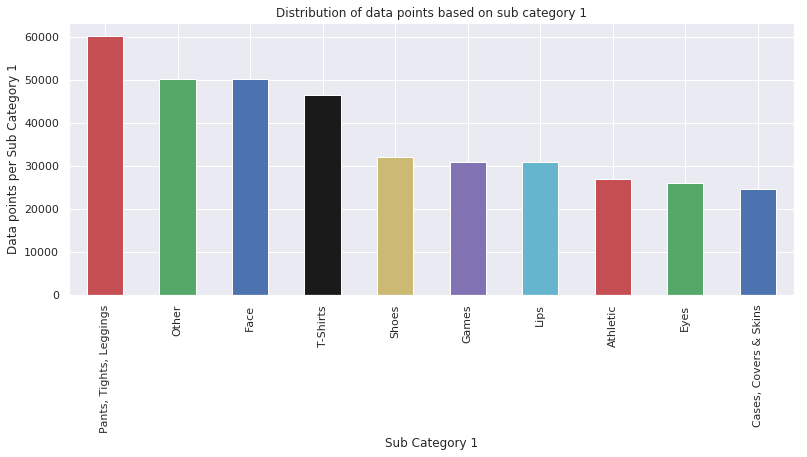

,sub_cat2,data points count,%
0,"Pants, Tights, Leggings",60177,4.06
1,Other,50224,3.39
2,Face,50171,3.38
3,T-Shirts,46380,3.13
4,Shoes,32168,2.17
5,Games,30906,2.08
6,Lips,30871,2.08
7,Athletic,27059,1.83
8,Eyes,26038,1.76
9,"Cases, Covers & Skins",24676,1.66


In [0]:
sub_cat2=train['sub_cat2'].value_counts()
print('Number of unique sub categories 1 : ',sub_cat2.size)

my_colors = ['r','g','b','k','y','m','c']
sub_cat2[0:10].plot(kind='bar',color=my_colors)
plt.xlabel('Sub Category 1')
plt.ylabel('Data points per Sub Category 1')
plt.title('Distribution of data points based on sub category 1')
plt.show()


keys=list(sub_cat2[0:10].keys())
values=list(sub_cat2[0:10].values)
percentage=[]
for i in range(len(sub_cat2[0:10])):
    percent=np.round(float(values[i]/len(train))*100,2)
    percentage.append(percent)    
df=pd.DataFrame()
df['sub_cat2']=keys
df['data points count']=values
df['%']=percentage
df

#### Observations :-
- There are a total 871 unique sub categories2
- Pants, Tights, Leggings sub category2 contains more number of data points


## brand_name

Number of unique brands :  4810


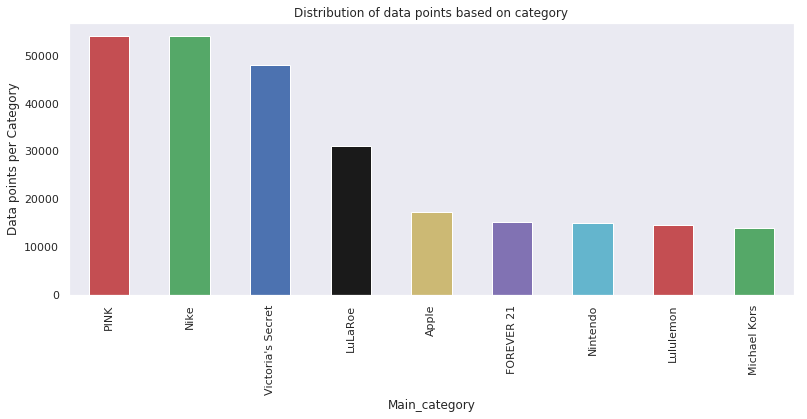

,Brand,data points count,%
0,PINK,54088,3.65
1,Nike,54043,3.65
2,Victoria's Secret,48036,3.24
3,LuLaRoe,31024,2.09
4,Apple,17322,1.17
5,FOREVER 21,15186,1.02
6,Nintendo,15007,1.01
7,Lululemon,14558,0.98
8,Michael Kors,13928,0.94


In [0]:
brand=train['brand_name'].value_counts()
print('Number of unique brands : ',brand.size)

my_colors = ['r','g','b','k','y','m','c']
brand[1:10].plot(kind='bar',color=my_colors)
plt.xlabel('Main_category')
plt.ylabel('Data points per Category')
plt.title('Distribution of data points based on category')
plt.grid()
plt.show()

keys=list(brand[1:10].keys())
values=list(brand[1:10].values)
percentage=[]
for i in range(len(brand[1:10])):
    percent=np.round(float(values[i]/len(train))*100,2)
    percentage.append(percent)    
df=pd.DataFrame()
df['Brand']=keys
df['data points count']=values
df['%']=percentage
df

### Observations :-
- There are a total 4810 unique brands
- PINK and Nike have almost same number of data points


## Item_condition_id

In [0]:
condition=train['item_condition_id'].value_counts()
condition

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

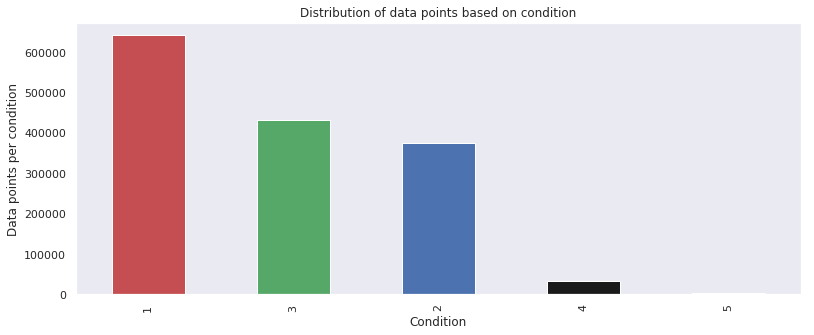

,Item_Condition_Id,data points count,%
0,1,640549,43.21
1,3,432161,29.15
2,2,375479,25.33
3,4,31962,2.16
4,5,2384,0.16


In [0]:
my_colors = ['r','g','b','k','y']
condition.plot(kind='bar',color=my_colors)
plt.xlabel('Condition')
plt.ylabel('Data points per condition')
plt.title('Distribution of data points based on condition')
plt.grid()
plt.show()

keys=list(condition.keys())
values=list(condition.values)
percentage=[]
for i in range(len(condition)):
    percent=np.round(float(values[i]/len(train))*100,2)
    percentage.append(percent)    
df=pd.DataFrame()
df['Item_Condition_Id']=keys
df['data points count']=values
df['%']=percentage
df

#### Observations :-
- There are a total 5 Item_Condition_Id's
- Item_Condition_Id '1' has  43.21% of the data points
- The Item_Condition_Id's  '4' and '5' have less than 3% of data points


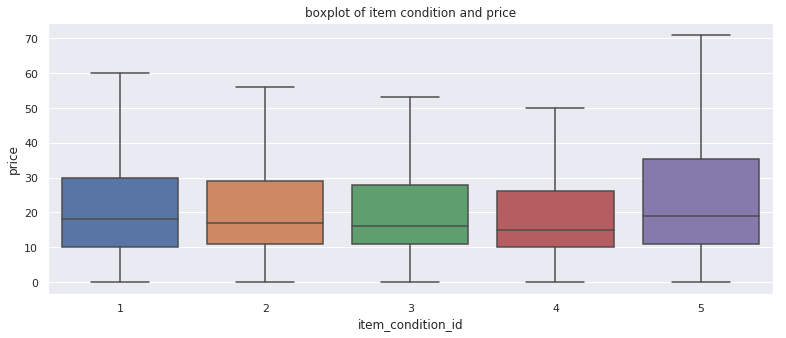

In [0]:
#boxplot of byte files
ax = sns.boxplot(x=train['item_condition_id'], y=train['price'],showfliers = False, orient = "v")
plt.title("boxplot of item condition and price")
plt.show()

#### Observations :-
- The items having Item_Condition_Id '5' have a highest price range when compared to other Item_Condition_Id's


## shipping

,shipping,data points count,%
0,0,819435,55.27
1,1,663100,44.73


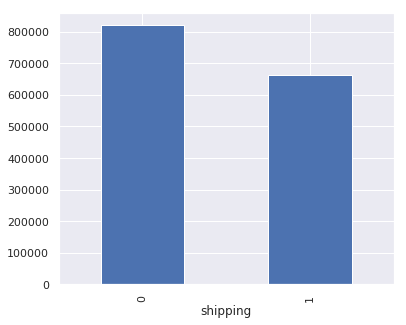

In [0]:
shipping=train['shipping'].value_counts()
train.groupby("shipping")['train_id'].count().plot.bar()

keys=list(shipping.keys())
values=list(shipping.values)
percentage=[]
for i in range(len(shipping)):
    percent=np.round(float(values[i]/len(train))*100,2)
    percentage.append(percent)    
df=pd.DataFrame()
df['shipping']=keys
df['data points count']=values
df['%']=percentage
df

#### Observations :-
- Shipping = 0 ,shipping is paid by buyer
- Shipping = 1 ,shipping is paid by seller
- Items with shipping value = 0 are more in number than items with items with shipping value = 1

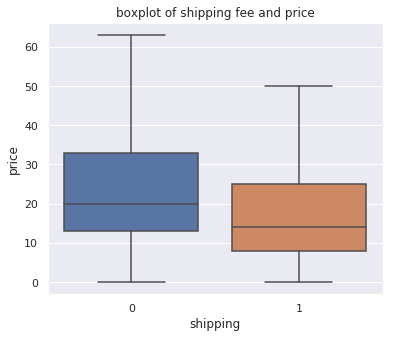

In [0]:
#boxplot of byte files
sns.set(rc={'figure.figsize':(6,5)})
ax = sns.boxplot(x=train['shipping'], y=train['price'],showfliers = False, orient = "v")
plt.title("boxplot of shipping fee and price")
plt.show()

#### Observations :-
- The price range of items with shipping value = 0 is more when compared to  items with items with shipping value = 1

## item_description

In [0]:
desc=" ".join(train['item_description'].astype(str))

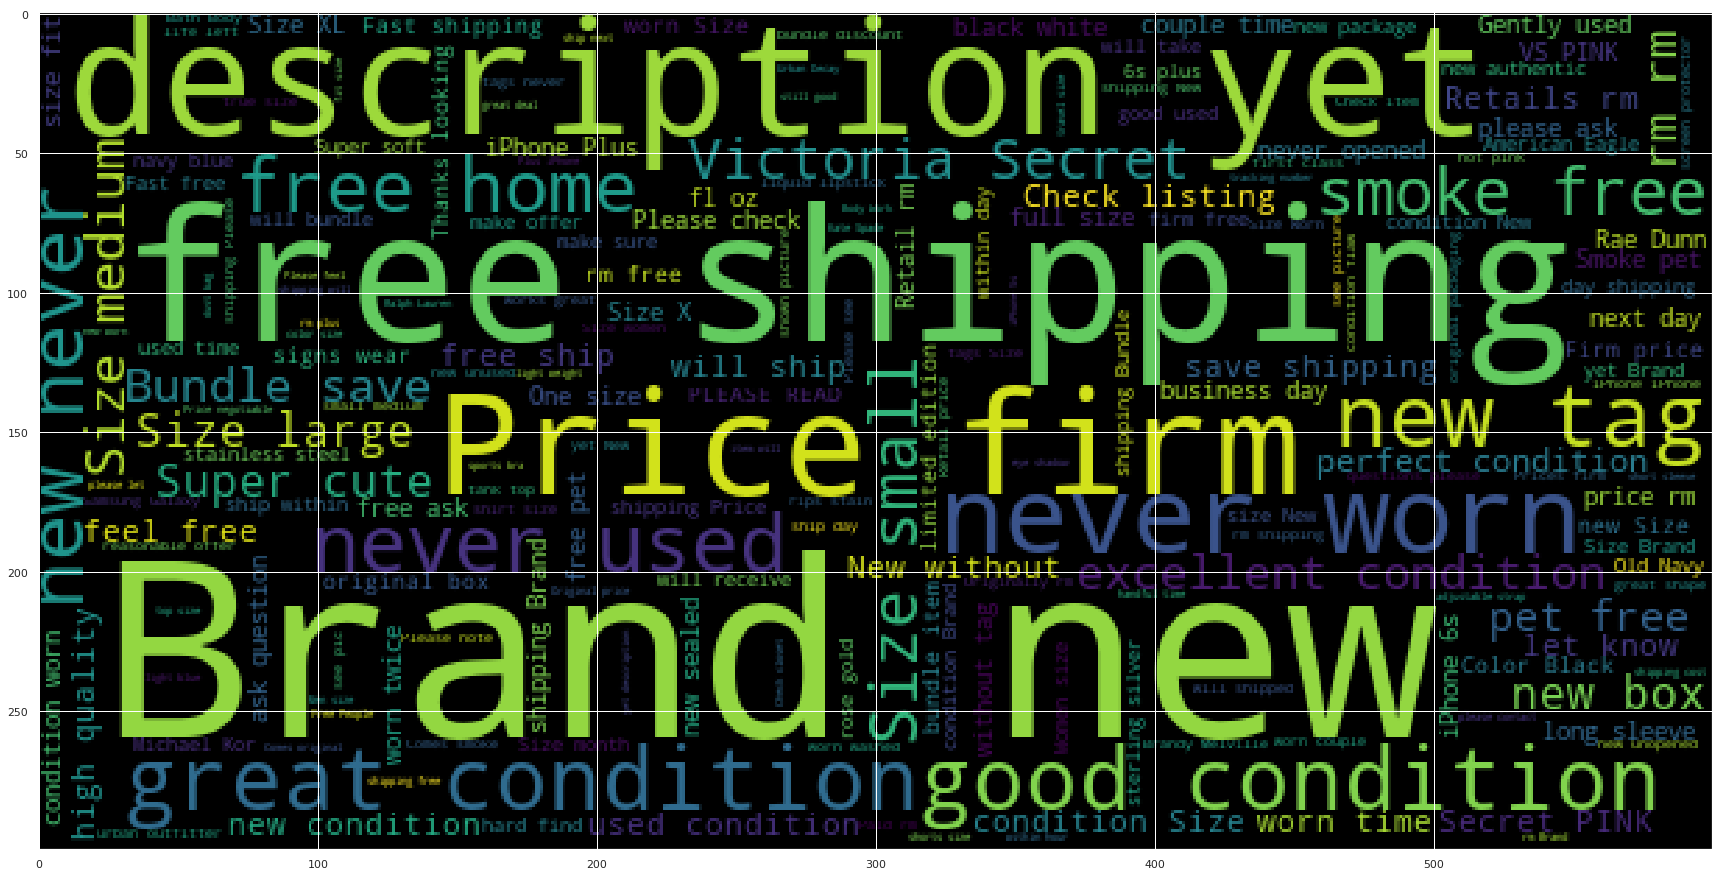

In [0]:
wordcloud = WordCloud(background_color='black',
                          width=600,
                          height=300,
                    ).generate(desc)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.show()

#### Observations :-
- The most frequent words in the item description are price,free shipping,firm,brand new,good condition,great condition,new tag,never worn,never used....


## name

In [0]:
name_join=" ".join(train['name'].astype(str))

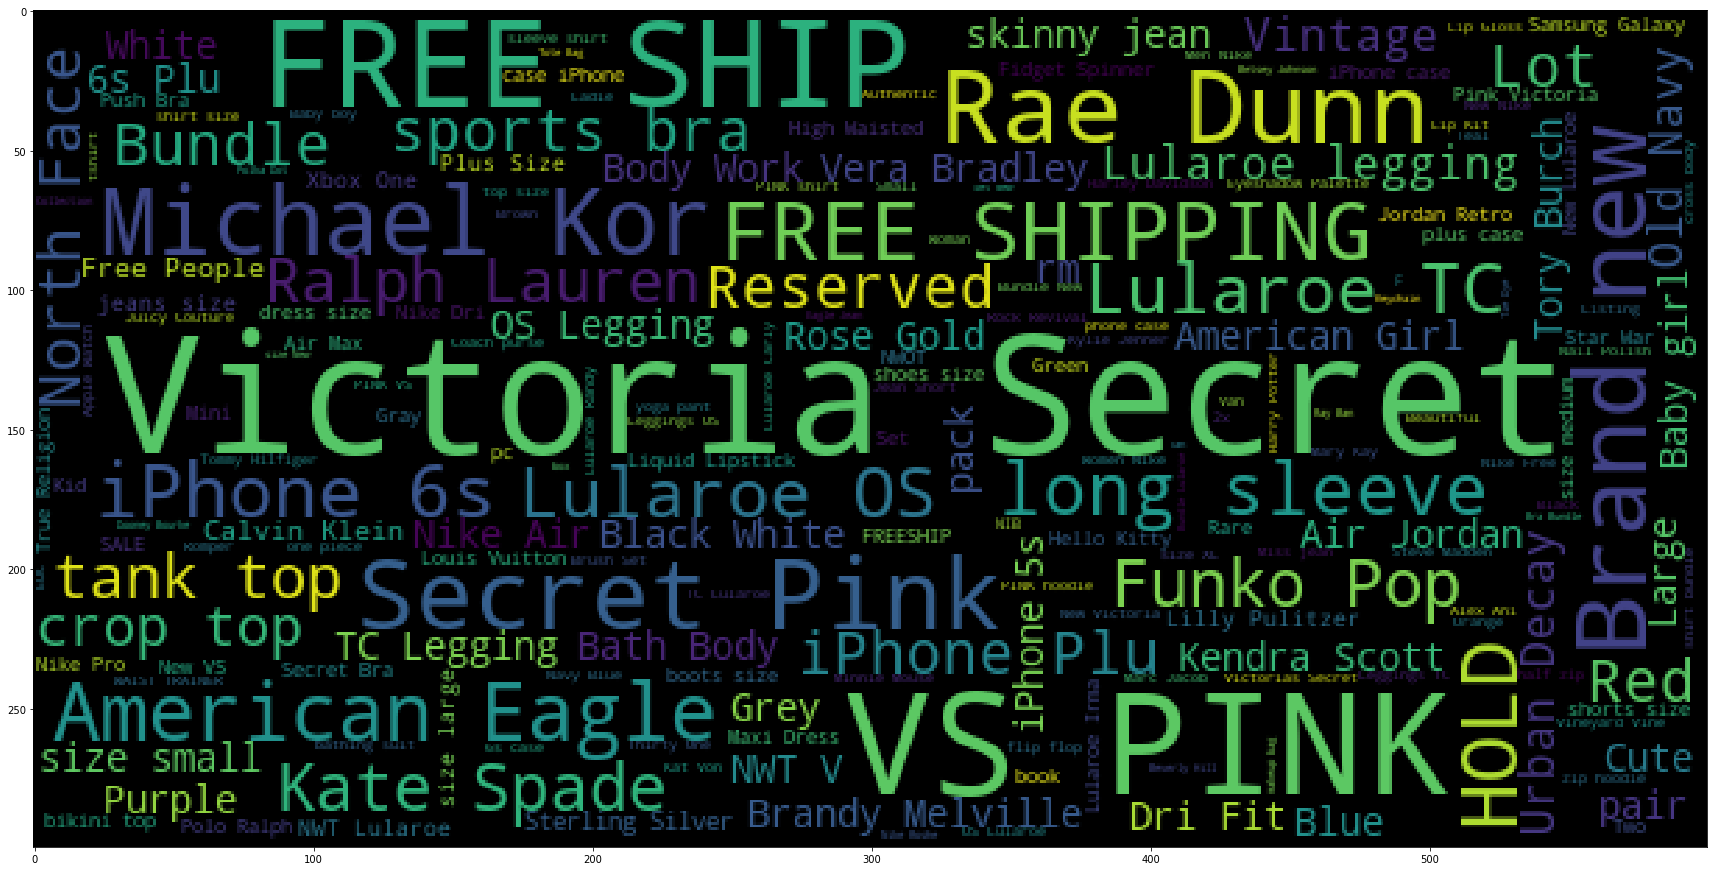

In [0]:
wordcloud = WordCloud(background_color='black',
                          width=600,
                          height=300,
                    ).generate(name_join)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.show()

#### Observations :-
- The most frequent words in the name are mostly the brand names

## 4. Preparing data for models

In [11]:
from sklearn.model_selection import train_test_split
import pickle
from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


In [12]:
train_price=train['price'].values
train.drop('price', axis=1, inplace=True)


<h2>4.1 Splitting data into Train, cross validation and test</h2>

In [13]:
x_train, x_cv, y_train, y_cv = train_test_split(train, train_price, test_size=0.3, random_state=0)
x_test=test


In [14]:
print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)
print(y_train.shape)
print(y_cv.shape)



(1037162, 9)
(444499, 9)
(3460725, 9)
(1037162,)
(444499,)


## 4.2 Encoding categorical and text features

### Encoding categorical features : main_category

In [15]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train['main_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_main_cat = vectorizer.transform(x_train['main_category'].values)
X_cv_main_cat = vectorizer.transform(x_cv['main_category'].values)
X_test_main_cat = vectorizer.transform(x_test['main_category'].values)

print(X_train_main_cat.shape)
print(X_cv_main_cat.shape)
print(X_test_main_cat.shape)

(1037162, 13)
(444499, 13)
(3460725, 13)


### Encoding categorical features : sub_cat1

In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train['sub_cat1'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_sub_cat1 = vectorizer.transform(x_train['sub_cat1'].values)
X_cv_sub_cat1 = vectorizer.transform(x_cv['sub_cat1'].values)
X_test_sub_cat1 = vectorizer.transform(x_test['sub_cat1'].values)

print(X_train_sub_cat1.shape)
print(X_cv_sub_cat1.shape)
print(X_test_sub_cat1.shape)

(1037162, 142)
(444499, 142)
(3460725, 142)


### Encoding categorical features : sub_cat2

In [17]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train['sub_cat2'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_sub_cat2 = vectorizer.transform(x_train['sub_cat2'].values)
X_cv_sub_cat2 = vectorizer.transform(x_cv['sub_cat2'].values)
X_test_sub_cat2 = vectorizer.transform(x_test['sub_cat2'].values)

print(X_train_sub_cat2.shape)
print(X_cv_sub_cat2.shape)
print(X_test_sub_cat2.shape)

(1037162, 955)
(444499, 955)
(3460725, 955)


### Encoding categorical features : brand_name

In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train['brand_name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_brand = vectorizer.transform(x_train['brand_name'].values)
X_cv_brand = vectorizer.transform(x_cv['brand_name'].values)
X_test_brand = vectorizer.transform(x_test['brand_name'].values)

print(X_train_brand.shape)
print(X_cv_brand.shape)
print(X_test_brand.shape)

(1037162, 4607)
(444499, 4607)
(3460725, 4607)


###  Encoding text features : item_description(BOW)

In [19]:
vectorizer = CountVectorizer(ngram_range=(1,2), max_features=100000)
vectorizer.fit(x_train['item_description'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_desc_bow = vectorizer.transform(x_train['item_description'].values)
X_cv_desc_bow = vectorizer.transform(x_cv['item_description'].values)
X_test_desc_bow = vectorizer.transform(x_test['item_description'].values)

print("After vectorizations")
print(X_train_desc_bow.shape)
print(X_cv_desc_bow.shape)
print(X_test_desc_bow.shape)
print("="*100)

After vectorizations
(1037162, 100000)
(444499, 100000)
(3460725, 100000)


###  Encoding text features : item_description(TF-IDF)

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=100000)
vectorizer.fit(x_train['item_description'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_desc_tfidf = vectorizer.transform(x_train['item_description'].values)
X_cv_desc_tfidf = vectorizer.transform(x_cv['item_description'].values)
X_test_desc_tfidf = vectorizer.transform(x_test['item_description'].values)

print("After vectorizations")
print(X_train_desc_tfidf.shape)
print(X_cv_desc_tfidf.shape)
print(X_test_desc_tfidf.shape)
print("="*100)

After vectorizations
(1037162, 100000)
(444499, 100000)
(3460725, 100000)


###  Encoding text features : item_description(AVG W2V)

In [19]:
f = open('glove.6B.50d.txt','r')
model = {}
for line in f:
    splitLine = line.split()
    word = splitLine[0]
    embedding = np.array([float(val) for val in splitLine[1:]])
    model[word] = embedding
glove_words =  set(model.keys())

In [20]:
X_train_desc_avg_w2v = [];
X_cv_desc_avg_w2v = [];
X_test_desc_avg_w2v = [];

#X_train

for sentence in tqdm(x_train['item_description'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_desc_avg_w2v.append(vector)
    
#X_cv
for sentence in tqdm(x_cv['item_description'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_cv_desc_avg_w2v.append(vector)
    
#X_test    
for sentence in tqdm(x_test['item_description'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_desc_avg_w2v.append(vector)
    
print("X_train:")
print(len(X_train_desc_avg_w2v))
print(len(X_train_desc_avg_w2v[0]))
print("="*50)

print("X_cv:")
print(len(X_cv_desc_avg_w2v))
print(len(X_cv_desc_avg_w2v[0]))
print("="*50)

print("X_test:")
print(len(X_test_desc_avg_w2v))
print(len(X_test_desc_avg_w2v[0]))
print("="*50)

100%|██████████| 3460725/3460725 [02:25<00:00, 23767.07it/s]

X_train:
1037162
50
X_cv:
444499
50
X_test:
3460725
50


###  Encoding text features : name(BOW)

In [21]:
vectorizer = CountVectorizer(ngram_range=(1,2), max_features=100000)
vectorizer.fit(x_train['name'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_name_bow = vectorizer.transform(x_train['name'].values)
X_cv_name_bow = vectorizer.transform(x_cv['name'].values)
X_test_name_bow = vectorizer.transform(x_test['name'].values)

print("After vectorizations")
print(X_train_name_bow.shape)
print(X_cv_name_bow.shape)
print(X_test_name_bow.shape)

print("="*100)

After vectorizations
(1037162, 100000)
(444499, 100000)
(3460725, 100000)


###  Encoding text features : name(TF-IDF)

In [22]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=100000)
vectorizer.fit(x_train['name'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_name_tfidf = vectorizer.transform(x_train['name'].values)
X_cv_name_tfidf = vectorizer.transform(x_cv['name'].values)
X_test_name_tfidf = vectorizer.transform(x_test['name'].values)

print("After vectorizations")
print(X_train_name_tfidf.shape)
print(X_cv_name_tfidf.shape)
print(X_test_name_tfidf.shape)

print("="*100)

After vectorizations
(1037162, 100000)
(444499, 100000)
(3460725, 100000)


###  Encoding text features : name(AVG W2V)

In [21]:
X_train_name_avg_w2v = [];
X_cv_name_avg_w2v = [];
X_test_name_avg_w2v = [];

#X_train

for sentence in tqdm(x_train['name'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_name_avg_w2v.append(vector)
    
#X_cv
for sentence in tqdm(x_cv['name'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_cv_name_avg_w2v.append(vector)
    
#X_test    
for sentence in tqdm(x_test['name'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_name_avg_w2v.append(vector)
    
print("X_train:")
print(len(X_train_name_avg_w2v))
print(len(X_train_name_avg_w2v[0]))
print("="*50)

print("X_cv:")
print(len(X_cv_name_avg_w2v))
print(len(X_cv_name_avg_w2v[0]))
print("="*50)

print("X_test:")
print(len(X_test_name_avg_w2v))
print(len(X_test_name_avg_w2v[0]))
print("="*50)

100%|██████████| 3460725/3460725 [00:37<00:00, 91569.57it/s] 

X_train:
1037162
50
X_cv:
444499
50
X_test:
3460725
50


### One hot encoding categorical feature : item_condition_id

In [22]:
encoder=OneHotEncoder()

X_train_condition=encoder.fit_transform(x_train['item_condition_id'].values.reshape(-1,1))
X_cv_condition=encoder.transform(x_cv['item_condition_id'].values.reshape(-1,1))
X_test_condition=encoder.transform(x_test['item_condition_id'].values.reshape(-1,1))

print(X_train_condition.shape)
print(X_cv_condition.shape)
print(X_test_condition.shape)

(1037162, 5)
(444499, 5)
(3460725, 5)


### One hot encoding categorical feature : shipping

In [23]:
encoder=OneHotEncoder()

X_train_shipping=encoder.fit_transform(x_train['shipping'].values.reshape(-1,1))
X_cv_shipping=encoder.transform(x_cv['shipping'].values.reshape(-1,1))
X_test_shipping=encoder.transform(x_test['shipping'].values.reshape(-1,1))

print(X_train_shipping.shape)
print(X_cv_shipping.shape)
print(X_test_shipping.shape)

(1037162, 2)
(444499, 2)
(3460725, 2)


### Converting numerical feature price to log(price)

In [24]:
y_train_log = np.log1p(y_train)
y_cv_log = np.log1p(y_cv)


## 4.3 Concatinating all the features

### SET 1 :-  categorical + item_description(BOW) + name (BOW)

In [26]:
X1_tr=hstack((X_train_name_bow,X_train_desc_bow,X_train_condition,X_train_brand,X_train_shipping
              ,X_train_main_cat,X_train_sub_cat1,X_train_sub_cat2)).tocsr()

X1_cr=hstack((X_cv_name_bow,X_cv_desc_bow,X_cv_condition,X_cv_brand,X_cv_shipping,
              X_cv_main_cat,X_cv_sub_cat1,X_cv_sub_cat2)).tocsr()

X1_te=hstack((X_test_name_bow,X_test_desc_bow,X_test_condition,X_test_brand,X_test_shipping,
              X_test_main_cat,X_test_sub_cat1,X_test_sub_cat2)).tocsr()

In [27]:
print(X1_tr.shape, y_train_log.shape)
print(X1_cr.shape, y_cv_log.shape)
print(X1_te.shape)


(1037162, 205724) (1037162,)
(444499, 205724) (444499,)
(3460725, 205724)


### SET 2 :-  categorical + item_description(TF-IDF) + name (TF-IDF)

In [28]:
X2_tr=hstack((X_train_name_tfidf,X_train_desc_tfidf,X_train_condition,X_train_brand,X_train_shipping
              ,X_train_main_cat,X_train_sub_cat1,X_train_sub_cat2)).tocsr()

X2_cr=hstack((X_cv_name_tfidf,X_cv_desc_tfidf,X_cv_condition,X_cv_brand,X_cv_shipping,
              X_cv_main_cat,X_cv_sub_cat1,X_cv_sub_cat2)).tocsr()

X2_te=hstack((X_test_name_tfidf,X_test_desc_tfidf,X_test_condition,X_test_brand,X_test_shipping,
              X_test_main_cat,X_test_sub_cat1,X_test_sub_cat2)).tocsr()

In [29]:
print(X2_tr.shape, y_train_log.shape)
print(X2_cr.shape, y_cv_log.shape)
print(X2_te.shape)


(1037162, 205724) (1037162,)
(444499, 205724) (444499,)
(3460725, 205724)


### SET 3 :-  categorical + item_description(AVG W2V) + name (AVG W2V)

In [25]:
X3_tr=hstack((X_train_name_avg_w2v,X_train_desc_avg_w2v,X_train_condition,X_train_brand,X_train_shipping
              ,X_train_main_cat,X_train_sub_cat1,X_train_sub_cat2)).tocsr()

X3_cr=hstack((X_cv_name_avg_w2v,X_cv_desc_avg_w2v,X_cv_condition,X_cv_brand,X_cv_shipping,
              X_cv_main_cat,X_cv_sub_cat1,X_cv_sub_cat2)).tocsr()

X3_te=hstack((X_test_name_avg_w2v,X_test_desc_avg_w2v,X_test_condition,X_test_brand,X_test_shipping,
              X_test_main_cat,X_test_sub_cat1,X_test_sub_cat2)).tocsr()

In [27]:
print(X3_tr.shape, y_train_log.shape)
print(X3_cr.shape, y_cv_log.shape)
print(X3_te.shape)


(1037162, 5824) (1037162,)
(444499, 5824) (444499,)
(3460725, 5824)


## 4.4 ML Models

### Performance metric : Root Mean Square Logarithmic Error

In [28]:
def rmsle(y_test, y_pred):  
    result = (np.sqrt(((y_test-y_pred)**2).mean())).round(4)
    return result

<h2><font color="red"> 4.4.1 Baseline model

In [32]:
#calculating mean of price of train data
y_train_mean = y_train_log.mean()

train_rmsle = rmsle(y_train_log,y_train_mean)
cv_rmsle = rmsle(y_cv_log,y_train_mean)

print("Train RMSLE for baseline model =",train_rmsle)
print("CV RMSLE for baseline model =",cv_rmsle)


Train RMSLE for baseline model = 0.745
CV RMSLE for baseline model = 0.7481


- Therefore the RMSLE for the ML models should be better than 0.7481

<h2><font color="red"> 4.4.2 RIDGE (Linear Rigression with L2 regularization)

## SET 1 :-  categorical + item_description(BOW) + name (BOW)

### Training the model - Hyperparameter tuning

alpha = 0.1 : Train RMSLE = 0.4093, CV RMSLE = 0.4567
alpha = 1 : Train RMSLE = 0.4098, CV RMSLE = 0.4565
alpha = 2 : Train RMSLE = 0.4104, CV RMSLE = 0.4562
alpha = 3 : Train RMSLE = 0.4109, CV RMSLE = 0.456
alpha = 4 : Train RMSLE = 0.4115, CV RMSLE = 0.4559
alpha = 5 : Train RMSLE = 0.412, CV RMSLE = 0.4557
alpha = 6 : Train RMSLE = 0.4126, CV RMSLE = 0.4556
alpha = 7 : Train RMSLE = 0.4131, CV RMSLE = 0.4555
alpha = 8 : Train RMSLE = 0.4136, CV RMSLE = 0.4554
alpha = 9 : Train RMSLE = 0.4141, CV RMSLE = 0.4554
alpha = 10 : Train RMSLE = 0.4146, CV RMSLE = 0.4553


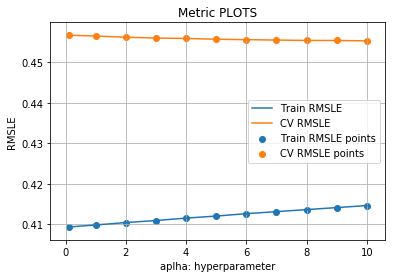

In [33]:
from sklearn.linear_model import Ridge

train_rmsle=[]
cv_rmsle=[]
alpha= [0.1,1,2,3,4,5,6,7,8,9,10]
for i in alpha:
    clf = Ridge(alpha=i)
    clf.fit(X1_tr,y_train_log)

    y_train_pred = clf.predict(X1_tr)
    y_cv_pred = clf.predict(X1_cr)

    train_error = rmsle(y_train_log, y_train_pred)
    cv_error = rmsle(y_cv_log, y_cv_pred)
    train_rmsle.append(train_error)
    cv_rmsle.append(cv_error)
    
    print('alpha = '+str(i)+' : Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)
    
plt.plot(alpha, train_rmsle, label='Train RMSLE')
plt.plot(alpha, cv_rmsle, label='CV RMSLE')

plt.scatter(alpha, train_rmsle, label='Train RMSLE points')
plt.scatter(alpha, cv_rmsle, label='CV RMSLE points')

plt.legend()
plt.xlabel("aplha: hyperparameter")
plt.ylabel("RMSLE")
plt.title("Metric PLOTS")
plt.grid()
plt.show()

<li>Chosose best hyper parameter in such a way that the CV RMSLE is low and the difference between Train RMSLE and CV RMSLE is less

<h6><font color='navy'> Best hyperparameter : alpha = 10

### Predicting the price with best hyperparameter

In [35]:
clf = Ridge(alpha=10)
clf.fit(X1_tr,y_train_log)

y_train_pred11 = clf.predict(X1_tr)
y_cv_pred11 = clf.predict(X1_cr)
y_test_pred11 = clf.predict(X1_te)
y11 = np.expm1(y_test_pred11)

train_error = rmsle(y_train_log, y_train_pred11)
cv_error = rmsle(y_cv_log, y_cv_pred11)
print('alpha = 10 : Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)

output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y11
output.head()

alpha = 10 : Train RMSLE = 0.4146, CV RMSLE = 0.4553


,test_id,price
0,0,10.117536
1,1,9.112697
2,2,44.461328
3,3,13.740187
4,4,7.102013


## SET 2 :-  categorical + item_description(TF-IDF) + name (TF-IDF)

alpha = 0.1 : Train RMSLE = 0.3763, CV RMSLE = 0.4632
alpha = 1 : Train RMSLE = 0.3863, CV RMSLE = 0.4476
alpha = 2 : Train RMSLE = 0.3944, CV RMSLE = 0.4446
alpha = 3 : Train RMSLE = 0.4006, CV RMSLE = 0.4441
alpha = 4 : Train RMSLE = 0.4057, CV RMSLE = 0.4446
alpha = 5 : Train RMSLE = 0.4099, CV RMSLE = 0.4453
alpha = 6 : Train RMSLE = 0.4135, CV RMSLE = 0.4462
alpha = 7 : Train RMSLE = 0.4167, CV RMSLE = 0.4472
alpha = 8 : Train RMSLE = 0.4195, CV RMSLE = 0.4481
alpha = 9 : Train RMSLE = 0.4221, CV RMSLE = 0.4491
alpha = 10 : Train RMSLE = 0.4244, CV RMSLE = 0.45


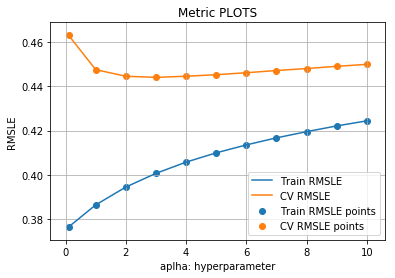

In [29]:
from sklearn.linear_model import Ridge

train_rmsle=[]
cv_rmsle=[]
alpha= [0.1,1,2,3,4,5,6,7,8,9,10]
for i in alpha:
    clf = Ridge(alpha=i)
    clf.fit(X2_tr,y_train_log)

    y_train_pred = clf.predict(X2_tr)
    y_cv_pred = clf.predict(X2_cr)

    train_error = rmsle(y_train_log, y_train_pred)
    cv_error = rmsle(y_cv_log, y_cv_pred)
    train_rmsle.append(train_error)
    cv_rmsle.append(cv_error)
    
    print('alpha = '+str(i)+' : Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)
    
plt.plot(alpha, train_rmsle, label='Train RMSLE')
plt.plot(alpha, cv_rmsle, label='CV RMSLE')

plt.scatter(alpha, train_rmsle, label='Train RMSLE points')
plt.scatter(alpha, cv_rmsle, label='CV RMSLE points')

plt.legend()
plt.xlabel("aplha: hyperparameter")
plt.ylabel("RMSLE")
plt.title("Metric PLOTS")
plt.grid()
plt.show()

<li>Chosose best hyper parameter in such a way that the CV RMSLE is low and the difference between Train RMSLE and CV RMSLE is less

<h6><font color='navy'> Best hyperparameter : alpha = 3

### Predicting the price with best hyperparameter

In [31]:
clf = Ridge(alpha=3)
clf.fit(X2_tr,y_train_log)

y_train_pred12 = clf.predict(X2_tr)
y_cv_pred12 = clf.predict(X2_cr)
y_test_pred12 = clf.predict(X2_te)
y12 = np.expm1(y_test_pred12)

train_error = rmsle(y_train_log, y_train_pred12)
cv_error = rmsle(y_cv_log, y_cv_pred12)
print('alpha = 3 : Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)

output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y12
output.head()

alpha = 3 : Train RMSLE = 0.4006, CV RMSLE = 0.4441


,test_id,price
0,0,10.034874
1,1,9.724997
2,2,47.595818
3,3,13.096653
4,4,7.438661


## SET 3 :-  categorical + item_description(AVG W2V) + name (AVG W2V)

alpha = 0.1 : Train RMSLE = 0.5606, CV RMSLE = 0.5646
alpha = 1 : Train RMSLE = 0.5609, CV RMSLE = 0.5644
alpha = 2 : Train RMSLE = 0.5611, CV RMSLE = 0.5645
alpha = 3 : Train RMSLE = 0.5613, CV RMSLE = 0.5645
alpha = 4 : Train RMSLE = 0.5615, CV RMSLE = 0.5646
alpha = 5 : Train RMSLE = 0.5616, CV RMSLE = 0.5647
alpha = 6 : Train RMSLE = 0.5618, CV RMSLE = 0.5648
alpha = 7 : Train RMSLE = 0.5619, CV RMSLE = 0.5648
alpha = 8 : Train RMSLE = 0.562, CV RMSLE = 0.5649
alpha = 9 : Train RMSLE = 0.5621, CV RMSLE = 0.565
alpha = 10 : Train RMSLE = 0.5622, CV RMSLE = 0.5651


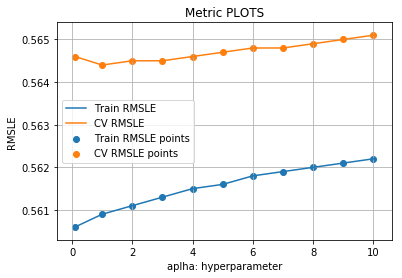

In [31]:
from sklearn.linear_model import Ridge

train_rmsle=[]
cv_rmsle=[]
alpha= [0.1,1,2,3,4,5,6,7,8,9,10]
for i in alpha:
    clf = Ridge(alpha=i)
    clf.fit(X3_tr,y_train_log)

    y_train_pred = clf.predict(X3_tr)
    y_cv_pred = clf.predict(X3_cr)

    train_error = rmsle(y_train_log, y_train_pred)
    cv_error = rmsle(y_cv_log, y_cv_pred)
    train_rmsle.append(train_error)
    cv_rmsle.append(cv_error)
    
    print('alpha = '+str(i)+' : Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)
    
plt.plot(alpha, train_rmsle, label='Train RMSLE')
plt.plot(alpha, cv_rmsle, label='CV RMSLE')

plt.scatter(alpha, train_rmsle, label='Train RMSLE points')
plt.scatter(alpha, cv_rmsle, label='CV RMSLE points')

plt.legend()
plt.xlabel("aplha: hyperparameter")
plt.ylabel("RMSLE")
plt.title("Metric PLOTS")
plt.grid()
plt.show()

<li>Chosose best hyper parameter in such a way that the CV RMSLE is low and the difference between Train RMSLE and CV RMSLE is less

<h6><font color='navy'> Best hyperparameter : alpha = 1

### Predicting the price with best hyperparameter

In [86]:
clf = Ridge(alpha=1)
clf.fit(X3_tr,y_train_log)

y_train_pred13 = clf.predict(X3_tr)
y_cv_pred13 = clf.predict(X3_cr)
y_test_pred13 = clf.predict(X3_te)
y13 = np.expm1(y_test_pred13)

train_error = rmsle(y_train_log, y_train_pred13)
cv_error = rmsle(y_cv_log, y_cv_pred13)
print('alpha = 1: Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)

output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y13
output.head()

alpha = 1 : Train RMSLE = 0.5256, CV RMSLE = 0.5339


,test_id,price
0,0,15.322902
1,1,9.898234
2,2,35.901699
3,3,22.456300
4,4,8.797033


<h2><font color="red"> 4.4.3 Random Forest Regressor


## SET 1 :-  categorical + item_description(BOW) + name (BOW)

### Training the model - Hyperparameter tuning

max_depth = 5 : Train RMSLE = 0.6714, CV RMSLE = 0.6738
max_depth = 10 : Train RMSLE = 0.6235, CV RMSLE = 0.6268
max_depth = 20 : Train RMSLE = 0.556, CV RMSLE = 0.5758
max_depth = 30 : Train RMSLE = 0.4982, CV RMSLE = 0.5438
max_depth = 40 : Train RMSLE = 0.4511, CV RMSLE = 0.5242
max_depth = 50 : Train RMSLE = 0.4138, CV RMSLE = 0.5134


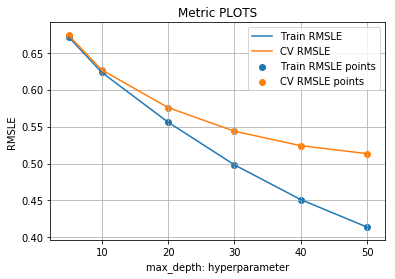

In [36]:

train_rmsle=[]
cv_rmsle=[]
max_depth= [5,10,20,30,40,50]
for i in max_depth:
    RF1 = RandomForestRegressor(max_depth=i, n_jobs=-1)
    RF1.fit(X1_tr,y_train_log)

    y_train_pred = RF1.predict(X1_tr)
    y_cv_pred = RF1.predict(X1_cr)

    train_error = rmsle(y_train_log, y_train_pred)
    cv_error = rmsle(y_cv_log, y_cv_pred)
    train_rmsle.append(train_error)
    cv_rmsle.append(cv_error)
    
    print('max_depth = '+str(i)+' : Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)
    
plt.plot(max_depth, train_rmsle, label='Train RMSLE')
plt.plot(max_depth, cv_rmsle, label='CV RMSLE')

plt.scatter(max_depth, train_rmsle, label='Train RMSLE points')
plt.scatter(max_depth, cv_rmsle, label='CV RMSLE points')

plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("RMSLE")
plt.title("Metric PLOTS")
plt.grid()
plt.show()

<li>Chosose best hyper parameter in such a way that the CV RMSLE is low and the difference between Train RMSLE and CV RMSLE is less

<h6><font color='navy'> Best hyperparameter : max_depth = 50

### Predicting the price with best hyperparameter

In [37]:
RF1 = RandomForestRegressor(max_depth=50, n_jobs=-1)
RF1.fit(X1_tr,y_traina_log)

y_train_pred21 = RF1.predict(X1_tr)
y_cv_pred21 = RF1.predict(X1_cr)
y_test_pred21 = RF1.predict(X1_te)
y21 = np.expm1(y_test_pred21)

train_error = rmsle(y_train_log, y_train_pred21)
cv_error = rmsle(y_cv_log, y_cv_pred21)
print('max_depth = 50: Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)

output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y21
output.head()

max_depth = 50: Train RMSLE = 0.4138, CV RMSLE = 0.5134


,test_id,price
0,0,8.413815
1,1,13.791215
2,2,21.588041
3,3,15.561349
4,4,11.093366


## SET 2 :-  categorical + item_description(TF-IDF) + name (TF-IDF)

### Training the model - Hyperparameter tuning

max_depth = 5 : Train RMSLE = 0.671, CV RMSLE = 0.6734
max_depth = 10 : Train RMSLE = 0.6229, CV RMSLE = 0.6268
max_depth = 20 : Train RMSLE = 0.5538, CV RMSLE = 0.5763
max_depth = 30 : Train RMSLE = 0.4947, CV RMSLE = 0.5459
max_depth = 40 : Train RMSLE = 0.4455, CV RMSLE = 0.5275
max_depth = 50 : Train RMSLE = 0.4081, CV RMSLE = 0.5177


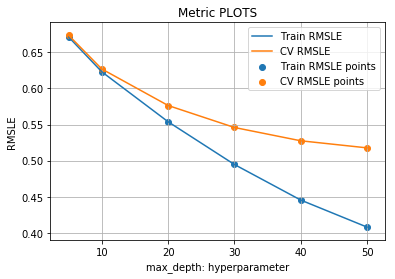

In [30]:

train_rmsle=[]
cv_rmsle=[]
max_depth= [5,10,20,30,40,50]
for i in max_depth:
    RF2 = RandomForestRegressor(max_depth=i, n_jobs=-1)
    RF2.fit(X2_tr,y_train_log)

    y_train_pred = RF2.predict(X2_tr)
    y_cv_pred = RF2.predict(X2_cr)

    train_error = rmsle(y_train_log, y_train_pred)
    cv_error = rmsle(y_cv_log, y_cv_pred)
    train_rmsle.append(train_error)
    cv_rmsle.append(cv_error)
    
    print('max_depth = '+str(i)+' : Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)
    
plt.plot(max_depth, train_rmsle, label='Train RMSLE')
plt.plot(max_depth, cv_rmsle, label='CV RMSLE')

plt.scatter(max_depth, train_rmsle, label='Train RMSLE points')
plt.scatter(max_depth, cv_rmsle, label='CV RMSLE points')

plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("RMSLE")
plt.title("Metric PLOTS")
plt.grid()
plt.show()

<li>Chosose best hyper parameter in such a way that the CV RMSLE is low and the difference between Train RMSLE and CV RMSLE is less

<h6><font color='navy'> Best hyperparameter : max_depth = 50

### Predicting the price with best hyperparameter

In [31]:
RF2 = RandomForestRegressor(max_depth=50, n_jobs=-1)
RF2.fit(X2_tr,y_train_log)

y_train_pred22 = RF2.predict(X2_tr)
y_cv_pred22 = RF2.predict(X2_cr)
y_test_pred22 = RF2.predict(X2_te)
y22 = np.expm1(y_test_pred22)

train_error = rmsle(y_train_log, y_train_pred22)
cv_error = rmsle(y_cv_log, y_cv_pred22)
print('max_depth = 50: Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)

output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y22
output.head()

max_depth = 50: Train RMSLE = 0.4081, CV RMSLE = 0.5177


,test_id,price
0,0,9.068544
1,1,13.329897
2,2,18.843231
3,3,15.651978
4,4,10.809444


## SET 3 :-  categorical + item_description(AVG W2V) + name (AVG W2V)

### Training the model - Hyperparameter tuning

max_depth = 5 : Train RMSLE = 0.6771, CV RMSLE = 0.6787
max_depth = 10 : Train RMSLE = 0.6324, CV RMSLE = 0.6375
max_depth = 20 : Train RMSLE = 0.5641, CV RMSLE = 0.6009
max_depth = 30 : Train RMSLE = 0.5011, CV RMSLE = 0.5796
max_depth = 40 : Train RMSLE = 0.432, CV RMSLE = 0.5659
max_depth = 50 : Train RMSLE = 0.3751, CV RMSLE = 0.5616


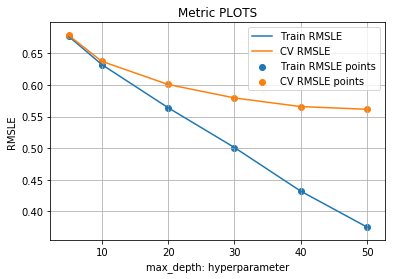

In [30]:

train_rmsle=[]
cv_rmsle=[]
max_depth= [5,10,20,30,40,50]
for i in max_depth:
    RF3 = RandomForestRegressor(max_depth=i, n_jobs=-1)
    RF3.fit(X3_tr,y_train_log)

    y_train_pred = RF3.predict(X3_tr)
    y_cv_pred = RF3.predict(X3_cr)

    train_error = rmsle(y_train_log, y_train_pred)
    cv_error = rmsle(y_cv_log, y_cv_pred)
    train_rmsle.append(train_error)
    cv_rmsle.append(cv_error)
    
    print('max_depth = '+str(i)+' : Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)
    
plt.plot(max_depth, train_rmsle, label='Train RMSLE')
plt.plot(max_depth, cv_rmsle, label='CV RMSLE')

plt.scatter(max_depth, train_rmsle, label='Train RMSLE points')
plt.scatter(max_depth, cv_rmsle, label='CV RMSLE points')

plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("RMSLE")
plt.title("Metric PLOTS")
plt.grid()
plt.show()

<li>Chosose best hyper parameter in such a way that the CV RMSLE is low and the difference between Train RMSLE and CV RMSLE is less
<li>If max_depth  is increased more than 50,the difference between train and cv RMSLE increases further

<h6><font color='navy'> Best hyperparameter : max_depth = 50

### Predicting the price with best hyperparameter

In [31]:
RF3 = RandomForestRegressor(max_depth=50, n_jobs=-1)
RF3.fit(X3_tr,y_train_log)

y_train_pred23 = RF3.predict(X3_tr)
y_cv_pred23 = RF3.predict(X3_cr)
y_test_pred23 = RF3.predict(X3_te)
y23 = np.expm1(y_test_pred23)

train_error = rmsle(y_train_log, y_train_pred23)
cv_error = rmsle(y_cv_log, y_cv_pred23)
print('max_depth = 50: Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)

output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y23
output.head()

max_depth = 50: Train RMSLE = 0.3751, CV RMSLE = 0.5616


,test_id,price
0,0,7.682067
1,1,7.873678
2,2,18.109358
3,3,16.947522
4,4,12.140816


<h2><font color="red"> 4.4.4 XGBOOST Regressor

## SET 1 :-  categorical + item_description(BOW) + name (BOW)

### Training the model - Hyperparameter tuning

[16:46:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
n_estimators = 1000 : Train RMSLE = 0.5198, CV RMSLE = 0.523
n_estimators = 2000 : Train RMSLE = 0.4956, CV RMSLE = 0.5007
n_estimators = 3000 : Train RMSLE = 0.4816, CV RMSLE = 0.4885
n_estimators = 4000 : Train RMSLE = 0.4717, CV RMSLE = 0.4803
n_estimators = 5000 : Train RMSLE = 0.464, CV RMSLE = 0.4742


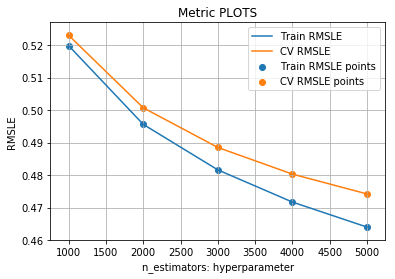

In [42]:
n_estimators=[1000,2000,3000,4000,5000]
train_rmsle=[]
cv_rmsle=[]
for i in n_estimators:
    xgb1 = XGBRegressor(n_estimators=i, n_jobs=-1)
    xgb1.fit(X1_tr,y_train_log)
        
    y_train_pred = xgb1.predict(X1_tr)
    y_cv_pred = xgb1.predict(X1_cr)
    
    train_error = rmsle(y_train_log, y_train_pred)
    cv_error = rmsle(y_cv_log, y_cv_pred)
    
    train_rmsle.append(train_error)
    cv_rmsle.append(cv_error)

for i in range(len(n_estimators)):
    print('n_estimators = '+str(n_estimators[i])+' : Train RMSLE = '+str(train_rmsle[i])+', CV RMSLE =',cv_rmsle[i])
    
plt.plot(n_estimators, train_rmsle, label='Train RMSLE')
plt.plot(n_estimators, cv_rmsle, label='CV RMSLE')

plt.scatter(n_estimators, train_rmsle, label='Train RMSLE points')
plt.scatter(n_estimators, cv_rmsle, label='CV RMSLE points')

plt.legend()
plt.xlabel("n_estimators: hyperparameter")
plt.ylabel("RMSLE")
plt.title("Metric PLOTS")
plt.grid()
plt.show()

<li>Chosose best hyper parameter in such a way that the CV RMSLE is low and the difference between Train RMSLE and CV RMSLE is less

<h6><font color='navy'> Best hyperparameter : n_estimators = 5000

### Predicting the price with best hyperparameter

In [43]:
xgb1 = XGBRegressor(n_estimators=5000, n_jobs=-1)
xgb1.fit(X1_tr,y_train_log)

y_train_pred31 = xgb1.predict(X1_tr)
y_cv_pred31 = xgb1.predict(X1_cr)
y_test_pred31 = xgb1.predict(X1_te)
y31 = np.expm1(y_test_pred31)

train_error = rmsle(y_train_log, y_train_pred31)
cv_error = rmsle(y_cv_log, y_cv_pred31)
print('n_estimators = 5000: Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)

output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y31
output.head()

n_estimators = 5000: Train RMSLE = 0.464, CV RMSLE = 0.4742


,test_id,price
0,0,10.101706
1,1,10.125776
2,2,41.787136
3,3,16.078148
4,4,8.644748


## SET 2 :-  categorical + item_description(TF-IDF) + name (TF-IDF)

### Training the model - Hyperparameter tuning

[12:15:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:49:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:33:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
n_estimators = 1000 : Train RMSLE = 0.5183, CV RMSLE = 0.5222
n_estimators = 2000 : Train RMSLE = 0.4934, CV RMSLE = 0.5
n_estimators = 3000 : Train RMSLE = 0.4786, CV RMSLE = 0.4878
n_estimators = 4000 : Train RMSLE = 0.4681, CV RMSLE = 0.4796
n_estimators = 5000 : Train RMSLE = 0.4598, CV RMSLE = 0.4737


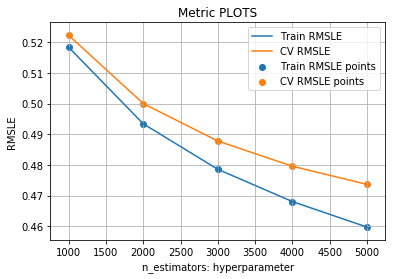

In [32]:
n_estimators=[1000,2000,3000,4000,5000]
train_rmsle=[]
cv_rmsle=[]
for i in n_estimators:
    xgb2 = XGBRegressor(n_estimators=i, n_jobs=-1)
    xgb2.fit(X2_tr,y_train_log)
        
    y_train_pred = xgb2.predict(X2_tr)
    y_cv_pred = xgb2.predict(X2_cr)
    
    train_error = rmsle(y_train_log, y_train_pred)
    cv_error = rmsle(y_cv_log, y_cv_pred)
    
    train_rmsle.append(train_error)
    cv_rmsle.append(cv_error)

for i in range(len(n_estimators)):
    print('n_estimators = '+str(n_estimators[i])+' : Train RMSLE = '+str(train_rmsle[i])+', CV RMSLE =',cv_rmsle[i])
    
plt.plot(n_estimators, train_rmsle, label='Train RMSLE')
plt.plot(n_estimators, cv_rmsle, label='CV RMSLE')

plt.scatter(n_estimators, train_rmsle, label='Train RMSLE points')
plt.scatter(n_estimators, cv_rmsle, label='CV RMSLE points')

plt.legend()
plt.xlabel("n_estimators: hyperparameter")
plt.ylabel("RMSLE")
plt.title("Metric PLOTS")
plt.grid()
plt.show()

<li>Chosose best hyper parameter in such a way that the CV RMSLE is low and the difference between Train RMSLE and CV RMSLE is less

<h6><font color='navy'> Best hyperparameter : n_estimators = 5000

### Predicting the price with best hyperparameter

In [40]:
xgb2 = XGBRegressor(n_estimators=5000, n_jobs=-1)
xgb2.fit(X2_tr,y_train_log)

y_train_pred32 = xgb2.predict(X2_tr)
y_cv_pred32 = xgb2.predict(X2_cr)
y_test_pred32 = xgb2.predict(X2_te)
y32 = np.expm1(y_test_pred32)

train_error = rmsle(y_train_log, y_train_pred32)
cv_error = rmsle(y_cv_log, y_cv_pred32)
print('n_estimators = 5000: Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)

output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y32
output.head()

n_estimators = 5000: Train RMSLE = 0.4598, CV RMSLE = 0.4737


,test_id,price
0,0,10.054468
1,1,9.273506
2,2,36.111198
3,3,16.014009
4,4,8.687569


<h2><font color="red"> 4.4.5 FM_FTRL : Factorization Machine Follow The Regularization Leader

<li>FTRL : Linear model Proximal-FTRL that has become the most popular algorithm for online learning of linear models in Kaggle competions.
<li>FM_FTRL : Factorization Machines. Linear effects estimated with FTRL and factor effects estimated with adaptive SGD. Prediction and estimation multithreaded across factors.
<li>The adaptive SGD optimizer works like Adagrad, but pools the adaptive learning rates across hidden nodes
<li> https://medium.com/@dhirajreddy13/factorization-machines-and-follow-the-regression-leader-for-dummies-7657652dce69
<li>https://github.com/anttttti/Wordbatch

In [35]:
import wordbatch

from wordbatch.extractors import WordBag, WordHash
from wordbatch.models import FTRL, FM_FTRL

## SET 2 :-  categorical + item_description(TF-IDF) + name (TF-IDF)

### Training the model

In [35]:
model2 = FM_FTRL(D=X2_tr.shape[1], iters=30,threads=12)
model2.fit(X2_tr, y_train_log)

Total e: 377643.1475837479
Total e: 341803.12466171145
Total e: 330506.3605100804
Total e: 323437.69987354666
Total e: 318344.51223147573
Total e: 314403.7157800503
Total e: 311214.55642854807
Total e: 308545.0574811478
Total e: 306256.0323824083
Total e: 304256.45794740133
Total e: 302480.1005421136
Total e: 300881.9795513508
Total e: 299425.39580756065
Total e: 298086.5378725825
Total e: 296845.02048604883
Total e: 295684.9323144622
Total e: 294593.522086264
Total e: 293560.29587708524
Total e: 292575.8203008837
Total e: 291634.07565514586
Total e: 290729.6716189085
Total e: 289856.8120925457
Total e: 289011.63114346453
Total e: 288190.7873436062
Total e: 287391.4172179394
Total e: 286610.48094992316
Total e: 285845.8356756173
Total e: 285095.28089128213
Total e: 284357.3784256046
Total e: 283630.76408343716


### Predicting the price 

In [36]:
y_train_pred42 = model2.predict(X2_tr)
y_cv_pred42 = model2.predict(X2_cr)
y_test_pred42 = model2.predict(X2_te)
y42 = np.expm1(y_test_pred42)

train_error = rmsle(y_train_log, y_train_pred42)
cv_error = rmsle(y_cv_log, y_cv_pred42)
print('For FM_FTRL model : Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)

output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y42
output.head()

For FM_FTRL model : Train RMSLE = 0.3649, CV RMSLE = 0.4336


,test_id,price
0,0,7.698370
1,1,9.614035
2,2,59.650479
3,3,11.601917
4,4,7.976456


## SET 3 :-  categorical + item_description(AVG W2V) + name (AVG W2V)

### Training the model

In [36]:
model3 = FM_FTRL(D=X3_tr.shape[1], iters=30,threads=12)
model3.fit(X3_tr, y_train_log)

Total e: 442950.9680900332
Total e: 427700.8791989619
Total e: 424035.81006830034
Total e: 421871.7678670636
Total e: 420337.04699014913
Total e: 419150.49092827016
Total e: 418184.8218341588
Total e: 417369.65393494605
Total e: 416664.78371579916
Total e: 416045.0856029353
Total e: 415492.3370035744
Total e: 414993.1310035172
Total e: 414540.8973219683
Total e: 414129.0165711676
Total e: 413752.02360381064
Total e: 413406.4138166123
Total e: 413089.2309892627
Total e: 412799.00746255
Total e: 412533.4660628584
Total e: 412291.3258472642
Total e: 412071.51962643326
Total e: 411873.4947077818
Total e: 411696.52973678085
Total e: 411540.5063132007
Total e: 411405.85074343026
Total e: 411294.24748696666
Total e: 411206.0764196147
Total e: 411141.99366735347
Total e: 411102.6643412086
Total e: 411088.9743958102


In [38]:
y_train_pred43 = model3.predict(X3_tr)
y_cv_pred43 = model3.predict(X3_cr)
y_test_pred43 = model3.predict(X3_te)
y43 = np.expm1(y_test_pred43)

train_error = rmsle(y_train_log, y_train_pred43)
cv_error = rmsle(y_cv_log, y_cv_pred43)
print('For FM_FTRL model : Train RMSLE = '+str(train_error)+', CV RMSLE =',cv_error)

output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y43
output.head()

For FM_FTRL model : Train RMSLE = 0.5256, CV RMSLE = 0.5339


,test_id,price
0,0,8.392869
1,1,8.601333
2,2,44.067662
3,3,18.482287
4,4,7.012417


## DL models

<h2><font color="red"> 4.4.7 MLP

In [39]:
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten,concatenate,Input,LSTM
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.initializers import he_normal
from keras.initializers import RandomNormal

Using TensorFlow backend.


In [40]:
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].todense()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [41]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [47]:
def mlp_validate(model,X,Y):
    s=5000
    s1=int(Y%s)
    size=Y-s1
    test=[]
    for i in range(0,size,5000):
        ind=np.arange(i,i+5000)
        sample=X[ind,:].todense()
        y_pred=model.predict(sample)
        y_pred=list(map(float,y_pred))
        y_pred=list(np.array(y_pred))
        test=test+y_pred
    ind=np.arange(len(test),Y)
    sample=X[ind,:].todense()
    y_pred=model.predict(sample)
    y_pred=list(map(float,y_pred))
    y_pred=list(np.array(y_pred))
    test=test+y_pred
    return test

## SET 1 :-  categorical + item_description(BOW) + name (BOW)

In [34]:
model_batch1 = Sequential()

model_batch1.add(Dense(256, activation='relu', input_shape=(X1_tr.shape[1],), kernel_initializer='normal'))

model_batch1.add(Dense(128, activation='relu', kernel_initializer='normal'))

model_batch1.add(Dense(64, activation='relu', kernel_initializer='normal'))

model_batch1.add(Dense(output_dim=1))

model_batch1.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               52665600  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 52,706,817
Trainable params: 52,706,817
Non-trainable params: 0
_________________________________________________________________


In [35]:
model_batch1.compile(optimizer='adam', loss=root_mean_squared_error)


In [36]:
x1=X1_tr.shape[0]/128


In [37]:
model_batch1.fit_generator(generator=batch_generator(X1_tr, y_train_log, 128, True),
                    nb_epoch=1,steps_per_epoch=x1,
                    shuffle=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1
8103/8102 [==============================] - 4745s 586ms/step - loss: 0.4703


In [45]:
y_train_pred51=mlp_validate(model_batch1,X1_tr,X1_tr.shape[0])
y_cv_pred51=mlp_validate(model_batch1,X1_cr,X1_cr.shape[0])
print('Train RMLSE =',rmsle(y_train_log,y_train_pred51))
print('CV RMLSE =',rmsle(y_cv_log,y_cv_pred51))

Train RMLSE = 0.3696
CV RMLSE = 0.4336


In [47]:
y_test_pred51=mlp_validate(model_batch1,X1_te,X1_te.shape[0])
y51 = np.expm1(y_test_pred51)
output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y51
output.head()

,test_id,price
0,0,5.725799
1,1,12.961642
2,2,66.329922
3,3,12.149285
4,4,7.716349


## SET 2 :-  categorical + item_description(TF-IDF) + name (TF-IDF)

In [89]:
model_batch = Sequential()

model_batch.add(Dense(256, activation='relu', input_shape=(X2_tr.shape[1],), kernel_initializer='normal'))

model_batch.add(Dense(128, activation='relu', kernel_initializer='normal'))

model_batch.add(Dense(64, activation='relu', kernel_initializer='normal'))

model_batch.add(Dense(output_dim=1))

model_batch.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               52665600  
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 52,706,817
Trainable params: 52,706,817
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_batch.compile(optimizer='adam', loss=root_mean_squared_error)


In [42]:
x=X2_tr.shape[0]/128


In [43]:
model_batch.fit_generator(generator=batch_generator(X2_tr, y_train_log, 128, True),
                    nb_epoch=1,steps_per_epoch=x,
                    shuffle=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1
8103/8102 [==============================] - 3157s 390ms/step - loss: 0.4626


In [78]:
y_train_pred52=mlp_validate(model_batch,X2_tr,X2_tr.shape[0])
y_cv_pred52=mlp_validate(model_batch,X2_cr,X2_cr.shape[0])
print('Train RMLSE =',rmsle(y_train_log,y_train_pred52))
print('CV RMLSE =',rmsle(y_cv_log,y_cv_pred52))

Train RMLSE = 3741
CV RMLSE = 4327


### Predicting the price 

In [81]:
y_test_pred52=mlp_validate(model_batch,X2_te,X2_te.shape[0])
y52 = np.expm1(y_test_pred52)
output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y52
output.head()

,test_id,price
0,0,8.264034
1,1,9.970138
2,2,81.184289
3,3,12.924566
4,4,8.285819


## SET 3 :-  categorical + item_description(AVG W2V) + name (AVG W2V)

In [43]:
model_batch3 = Sequential()

model_batch3.add(Dense(256, activation='relu', input_shape=(X3_tr.shape[1],), kernel_initializer='normal'))

model_batch3.add(Dense(128, activation='relu', kernel_initializer='normal'))

model_batch3.add(Dense(64, activation='relu', kernel_initializer='normal'))

model_batch3.add(Dense(output_dim=1))

model_batch3.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               1491200   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,532,417
Trainable params: 1,532,417
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_batch3.compile(optimizer='adam', loss=root_mean_squared_error)


In [45]:
x3=X3_tr.shape[0]/128


In [46]:
model_batch3.fit_generator(generator=batch_generator(X3_tr, y_train_log, 128, True),
                    nb_epoch=1,steps_per_epoch=x3,
                    shuffle=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1
8103/8102 [==============================] - 244s 30ms/step - loss: 0.5527


In [61]:
def mlp_validate(model,X,Y):
    s=20000
    s1=int(Y%s)
    size=Y-s1
    pred=[]
    for i in range(0,size,20000):
        ind=np.arange(i,i+20000)
        sample=X[ind,:].todense()
        y_pred=model.predict(sample)
        y_pred=list(map(float,y_pred))
        y_pred=list(np.array(y_pred))
        pred=pred+y_pred
    ind=np.arange(len(pred),Y)
    sample=X[ind,:].todense()
    y_pred=model.predict(sample)
    y_pred=list(map(float,y_pred))
    y_pred=list(np.array(y_pred))
    pred=pred+y_pred
    return pred

In [69]:
y_train_pred53=mlp_validate(model_batch3,X3_tr,X3_tr.shape[0])
y_cv_pred53=mlp_validate(model_batch3,X3_cr,X3_cr.shape[0])
print('Train RMLSE =',rmsle(y_train_log,y_train_pred53))
print('CV RMLSE =',rmsle(y_cv_log,y_v_pred53))

Train RMLSE = 0.5328
CV RMLSE = 0.5406


### Predicting the price 

In [72]:
y_test_pred53=mlp_validate(model_batch3,X3_te,X3_te.shape[0])
y53 = np.expm1(y_test_pred53)
output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=y53
output.head()

,test_id,price
0,0,9.139111
1,1,8.705856
2,2,29.029055
3,3,19.025232
4,4,6.893620


<h2><font color="red">Comparision of all models

In [79]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = [ "Model",'Vectorizer',"Train RMSLE","CV RMSLE"]

x.add_row(["Ridge",'BOW',0.4146, 0.4553])
x.add_row(["Ridge",'TF-IDF',0.4006, 0.4441])
x.add_row(["Ridge",'Word2Vec',0.5609, 0.5644])

x.add_row(["Random Forest Regressor",'BOW',0.4138, 0.5134])
x.add_row(["Random Forest Regressor",'TF-IDF',0.4081, 0.5177])
x.add_row(["Random Forest Regressor",'Word2Vec',0.3751, 0.5616])

x.add_row(["XGBOOST Regressor",'BOW',0.4640, 0.4742])
x.add_row(["XGBOOST Regressor",'TF-IDF',0.4598, 0.4737])

x.add_row(["FM_FTRL",'TF-IDF', 0.3649,0.4336])
x.add_row(["FM_FTRL",'Word2Vec', 0.5256,0.5339])

x.add_row(["MLP",'BOW',0.3696, 0.4336])
x.add_row(["MLP",'TF-IDF',0.3741, 0.4327])
x.add_row(["MLP",'Word2Vec',0.5328, 0.5406])

print(x)

+-------------------------+------------+-------------+----------+
|          Model          | Vectorizer | Train RMSLE | CV RMSLE |
+-------------------------+------------+-------------+----------+
|          Ridge          |    BOW     |    0.4146   |  0.4553  |
|          Ridge          |   TF-IDF   |    0.4006   |  0.4441  |
|          Ridge          |  Word2Vec  |    0.5609   |  0.5644  |
| Random Forest Regressor |    BOW     |    0.4138   |  0.5134  |
| Random Forest Regressor |   TF-IDF   |    0.4081   |  0.5177  |
| Random Forest Regressor |  Word2Vec  |    0.3751   |  0.5616  |
|    XGBOOST Regressor    |    BOW     |    0.464    |  0.4742  |
|    XGBOOST Regressor    |   TF-IDF   |    0.4598   |  0.4737  |
|         FM_FTRL         |   TF-IDF   |    0.3649   |  0.4336  |
|         FM_FTRL         |  Word2Vec  |    0.5256   |  0.5339  |
|           MLP           |    BOW     |    0.3696   |  0.4336  |
|           MLP           |   TF-IDF   |    0.3741   |  0.4327  |
|         

<h4><font color='navy'>Out of 3 vectorizations, the TF-IDF vectorizations has given the least RMSLE value for all the models

## Combining the best models : RIDGE + FM_FTRL + MLP

In [76]:
print(rmsle(y_cv_log,y_cv_pred12))   #Ridge
print(rmsle(y_cv_log,y_cv_pred42))   #FM_FTRL
print(rmsle(y_cv_log,y_cv_pred52))   #MLP


0.4441
0.4336
0.4327


In [77]:
p1=np.array(y_cv_pred12)
p2=np.array(y_cv_pred42)
p3=np.array(y_cv_pred52)

In [78]:
x1=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
x2=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
x3=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
for i in x1:
    for j in x2:
        for k in x3:
            if(i+j+k==1):
                y=(i*p1)+(j*p2)+(k*p3)
                error=rmsle(y_cv_log,y)
                print('i = '+str(i)+', j = '+str(j)+', k = '+str(k)+': RMSLE =',error)

i = 0.1, j = 0.1, k = 0.8: RMSLE = 0.4289
i = 0.1, j = 0.2, k = 0.7: RMSLE = 0.4274
i = 0.1, j = 0.3, k = 0.6: RMSLE = 0.4265
i = 0.1, j = 0.4, k = 0.5: RMSLE = 0.4261
i = 0.1, j = 0.5, k = 0.4: RMSLE = 0.4264
i = 0.1, j = 0.6, k = 0.3: RMSLE = 0.4272
i = 0.1, j = 0.7, k = 0.2: RMSLE = 0.4287
i = 0.1, j = 0.8, k = 0.1: RMSLE = 0.4307
i = 0.2, j = 0.1, k = 0.7: RMSLE = 0.4282
i = 0.2, j = 0.2, k = 0.6: RMSLE = 0.4271
i = 0.2, j = 0.3, k = 0.5: RMSLE = 0.4267
i = 0.2, j = 0.4, k = 0.4: RMSLE = 0.4268
i = 0.2, j = 0.5, k = 0.3: RMSLE = 0.4275
i = 0.2, j = 0.6, k = 0.2: RMSLE = 0.4288
i = 0.3, j = 0.1, k = 0.6: RMSLE = 0.4281
i = 0.3, j = 0.2, k = 0.5: RMSLE = 0.4276
i = 0.3, j = 0.3, k = 0.4: RMSLE = 0.4276
i = 0.3, j = 0.4, k = 0.3: RMSLE = 0.4282
i = 0.3, j = 0.5, k = 0.2: RMSLE = 0.4293
i = 0.4, j = 0.1, k = 0.5: RMSLE = 0.4288
i = 0.4, j = 0.2, k = 0.4: RMSLE = 0.4287
i = 0.4, j = 0.3, k = 0.3: RMSLE = 0.4291
i = 0.4, j = 0.4, k = 0.2: RMSLE = 0.4302
i = 0.4, j = 0.5, k = 0.1: RMSLE =

<h3><font color='navy'> The best model : 0.1*(RIDGE) + 0.4*(FM_FTRL) + 0.5(MLP)
<li>CV RMSLE = 0.4261


In [85]:
test1=np.array(y_test_pred12)
test2=np.array(y_test_pred42)
test3=np.array(y_test_pred52)

In [88]:
test_price=(0.1*test1)+(0.4*test2)+(0.5*test3)
test_price = np.expm1(test_price)
output = pd.DataFrame()
output['test_id']=test['test_id'].values
output['price']=test_price
output.head()

,test_id,price
0,0,8.215897
1,1,9.804983
2,2,69.209163
3,3,12.412479
4,4,8.078251


<h1><font color='brown'> Steps followed in the case study:-</font></h1>

<li>Step 1:-  Loading the data
<li>Step 2:-  Data cleaning
<li>Step 3:-  Exploratory Data Analysis on all columns
<li>Step 4:-  Splitting the data into train and CV
<li>Step 5:-  Encoding all catogorical features
<li>Step 6:-  Applying various vectorizations on text features, BOW ,TF-IDF ,Word2Vec
<li>Step 7:-  Concatenating all features and preparing 3 sets of data
<li>Step 8:-  Applying various models and evaluating the model using RMSLE as metric
<li>Step 9:-  Comparision of all Models
<li>Step 10:-  Choosing the best models and vectorization
<li>Step 11:-  Ridge , FM_FTRL , MLP with TF-IDF vectorization gave the least RMSLE
<li>Step 12:-  The best model : 0.1*(RIDGE) + 0.4*(FM_FTRL) + 0.5(MLP) is submitted in kaggle and got a score of 0.42429

# Conclusion :-

In [1]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = [ "Model",'Vectorizer',"Train RMSLE","CV RMSLE"]

x.add_row(["Ridge",'BOW',0.4146, 0.4553])
x.add_row(["Ridge",'TF-IDF',0.4006, 0.4441])
x.add_row(["Ridge",'Word2Vec',0.5609, 0.5644])

x.add_row(["Random Forest Regressor",'BOW',0.4138, 0.5134])
x.add_row(["Random Forest Regressor",'TF-IDF',0.4081, 0.5177])
x.add_row(["Random Forest Regressor",'Word2Vec',0.3751, 0.5616])

x.add_row(["XGBOOST Regressor",'BOW',0.4640, 0.4742])
x.add_row(["XGBOOST Regressor",'TF-IDF',0.4598, 0.4737])

x.add_row(["FM_FTRL",'TF-IDF', 0.3649,0.4336])
x.add_row(["FM_FTRL",'Word2Vec', 0.5256,0.5339])

x.add_row(["MLP",'BOW',0.3696, 0.4336])
x.add_row(["MLP",'TF-IDF',0.3741, 0.4327])
x.add_row(["MLP",'Word2Vec',0.5328, 0.5406])

print(x)

+-------------------------+------------+-------------+----------+
|          Model          | Vectorizer | Train RMSLE | CV RMSLE |
+-------------------------+------------+-------------+----------+
|          Ridge          |    BOW     |    0.4146   |  0.4553  |
|          Ridge          |   TF-IDF   |    0.4006   |  0.4441  |
|          Ridge          |  Word2Vec  |    0.5609   |  0.5644  |
| Random Forest Regressor |    BOW     |    0.4138   |  0.5134  |
| Random Forest Regressor |   TF-IDF   |    0.4081   |  0.5177  |
| Random Forest Regressor |  Word2Vec  |    0.3751   |  0.5616  |
|    XGBOOST Regressor    |    BOW     |    0.464    |  0.4742  |
|    XGBOOST Regressor    |   TF-IDF   |    0.4598   |  0.4737  |
|         FM_FTRL         |   TF-IDF   |    0.3649   |  0.4336  |
|         FM_FTRL         |  Word2Vec  |    0.5256   |  0.5339  |
|           MLP           |    BOW     |    0.3696   |  0.4336  |
|           MLP           |   TF-IDF   |    0.3741   |  0.4327  |
|         

<h3><font color='navy'> The best model : 0.1*(RIDGE) + 0.4*(FM_FTRL) + 0.5(MLP)
<li>CV RMSLE = 0.4261
